## Yin Attack (InvertingGradients) on CIFAR-100
**Objective:** Reconstruct training data from gradients captured during federated learning simulation.


## 1. Setup and Imports


In [1]:
# Import required libraries
import torch
import torchvision
import breaching
import breaching.attacks as attacks
import breaching.cases as cases
import breaching.utils as utils
import torchvision.models as models
from pathlib import Path

### 2. Final Attack Configuration
This configuration is optimized for the highest possible fidelity, addressing the stability issues (LR), noise/blur (TV), and the architectural defense of ResNet18 (BN Stats).

| Parameter | Value | Reason |
| :--- | :--- | :--- |
| **Attack** | `invertinggradients` | The "successful" reconstruction method. |
| **Target Model** | ResNet18 | Model architecture. |
| **Dataset** | CIFAR-100 |  Target dataset. |
| **Batch Size** | 1 | Essential for perfect gradient inversion. |
| **Device** | GPU (CUDA) | Used for speed. |
| **Max Iterations** | $\mathbf{20,000}$ | Sufficient time for convergence. |
| **Learning Rate (LR)** | $\mathbf{0.001}$ | Ensures **stability** and high precision. |
| **Total Variation (TV)** | $\mathbf{1e-2}$ | Enforces **sharpness** and smoothness. |
| **Critical Fix** | $\mathbf{+reconstruct\_bn\_statistics=True}$ | **Bypasses the Batch Norm defense** for clear reconstruction. |

In [2]:
cfg = breaching.get_config(overrides = ["attack=invertinggradients",
                                        "+optim.max_iterations=20000", 
                                        "+optim.lr=0.001",  # learning rate
                                        "+regularization.total_variation=1e-2", # TV penalty
                                        "+reconstruct_bn_statistics=True" # batch normalization
                                       ])


print(f"Attack type: {cfg.attack.type}")

# The parameters are now created under the top-level config (cfg)
if 'optim' in cfg and 'regularization' in cfg:
    print(f"Attack learning rate: {cfg.optim.lr}")
    print(f"Attack max iterations: {cfg.optim.max_iterations}")
    print(f"Total Variation Reg: {cfg.regularization.total_variation}")
else:
    print("Configuration successful, but keys are nested differently. Proceeding to attack.")

/users/rbhandar/.local/lib/python3.12/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


Investigating use case single_imagenet with server type honest_but_curious.
Attack type: invertinggradients
Attack learning rate: 0.001
Attack max iterations: 20000
Total Variation Reg: 0.01


## 3. Load FL Gradients

In [3]:
# Load saved gradients from FL simulation
gradient_dir = Path("/scratch/project_2015432/Sec_FL_ritesh/src/fl_simulation/reports/fedavg_baseline/round_04")
gradient_files = sorted(gradient_dir.glob("fedavg_metrics_*_tensors.pt"))
grad_file = gradient_files[0]
gradient_data = torch.load(grad_file, map_location='cpu')

print(f"Loaded: {grad_file.name}")
print(f"Keys: {list(gradient_data.keys())}")
print(f"Clients: {list(gradient_data['raw_gradients'].keys())}")

# Check first client
client_id = list(gradient_data['raw_gradients'].keys())[0]
client_data = gradient_data['raw_gradients'][client_id]
num_steps = len(client_data['grads_per_step_raw'])

print(f"Client {client_id}: {num_steps} gradient steps")
print(f"Parameters: {len(client_data['grads_per_step_raw'][0])}")

Loaded: fedavg_metrics_04_tensors.pt
Keys: ['global_model_state', 'raw_gradients', 'model_updates', 'server_aggregate_delta']
Clients: [2, 11, 13, 3, 10]
Client 2: 1 gradient steps
Parameters: 62


## 4. Load Model Architecture

In [4]:
model_state = gradient_data['global_model_state']
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes
model.load_state_dict(model_state, strict=False)
model = model.cuda()
model.eval()
loss_fn = torch.nn.CrossEntropyLoss()
setup = dict(device=torch.device('cuda'), dtype=torch.float32)
attacker = breaching.attacks.prepare_attack(model, loss_fn, cfg.attack, setup)

/users/rbhandar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/rbhandar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model is loaded


## 5. Extract Client Gradients

In [5]:
# Get gradients from first client, first training step
client_id = list(gradient_data['raw_gradients'].keys())[0]
client_grads = gradient_data['raw_gradients'][client_id]
grad_dict = client_grads['grads_per_step_raw'][0]

print(f"Client: {client_id}")
print(f"Number of gradient tensors: {len(grad_dict)}")

Client: 2
Number of gradient tensors: 62


## 6. Prepare Attack Inputs: Gradients and Model State

In [6]:
# Define CIFAR-100 metadata and separate model parameters/buffers
class DataConfig:
    modality = "vision"
    size = (50_000,)
    classes = 100
    shape = (3, 32, 32)
    normalize = True
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

data_cfg = DataConfig()

parameters = []
buffers = []
for name, tensor in gradient_data['global_model_state'].items():
    if 'running' in name or 'num_batches' in name:
        buffers.append(tensor.cuda())
    else:
        parameters.append(tensor.cuda())

server_payload = [dict(
    parameters=parameters,
    buffers=buffers,
    metadata=data_cfg
)]

print(f"Parameters: {len(parameters)}")
print(f"Buffers: {len(buffers)}")

# Create gradients_ordered 
grad_dict = client_grads['grads_per_step_raw'][0]
gradients_ordered = []
for name, param in model.named_parameters():
    if name in grad_dict:
        gradients_ordered.append(grad_dict[name].cuda())
    else:
        print(f"Warning: {name} not found in gradients")

print(f"Reordered {len(gradients_ordered)} gradients to match model")

# Verify shapes match
print("\nVerifying alignment:")
for i, (g, p) in enumerate(zip(gradients_ordered, model.parameters())):
    if g.shape != p.shape:
        print(f"Mismatch at {i}: {g.shape} vs {p.shape}")
        break
else:
    print("All shapes match!")

# Create shared_data - using label 0 as initial guess
shared_data = [
    dict(
        gradients=gradients_ordered,
        buffers=None,
        metadata=dict(  
            num_data_points=1,
            labels=torch.tensor([0]).cuda(),  # Starting guess
            local_hyperparams=dict(
                lr=0.01,
                momentum=0.0,
                weight_decay=0.0,
                steps=1,
                data_per_step=1,
                labels=[torch.tensor([0]).cuda()],  # Also needed here!
            )
        )
    )
]

print("server_payload and shared_data created successfully!")
print("Using label=0 as initial guess (may not be the actual label)")

Parameters: 62
Buffers: 60
Reordered 62 gradients to match model

Verifying alignment:
All shapes match!
server_payload and shared_data created successfully!
Using label=0 as initial guess (may not be the actual label)


## 7. Execute Gradient Inversion Attack
**Warning:** This may take several minutes on GPU.

In [7]:
# Cell 7 - Execute Attack (FINAL CORRECTED VERSION)

print("Running Yin attack (20,000 iterations)...")
print("This will take 10-20 minutes...")

reconstructed_user_data, stats = attacker.reconstruct(
    server_payload, 
    shared_data,        
    server_secrets={},
    dryrun=False  
)

print("\nAttack completed!")
print(f"Keys: {list(reconstructed_user_data.keys())}")
print(f"Reconstructed data shape: {reconstructed_user_data['data'].shape}")
print(f"Reconstructed labels: {reconstructed_user_data['labels']}")

# Extract image from the dictionary
reconstructed_img = reconstructed_user_data['data'][0].cpu()  # Get first (and only) image
print("reconstructed_img variable is ready for visualization")

Running Yin attack (20,000 iterations)...
This will take 10-20 minutes...

Attack completed!
Keys: ['data', 'labels']
Reconstructed data shape: torch.Size([1, 3, 32, 32])
Reconstructed labels: tensor([0], device='cuda:0')
reconstructed_img variable is ready for visualization


## 8. Analyze Results

In [8]:
# Check what was reconstructed
print("Reconstructed data shape:", reconstructed_user_data['data'].shape)
print("Reconstructed labels:", reconstructed_user_data['labels'])


# Also show some stats
print(f"\nImage stats:")
print(f"Min pixel value: {reconstructed_img.min()}")
print(f"Max pixel value: {reconstructed_img.max()}")
print(f"Mean: {reconstructed_img.mean()}")


# The stats dictionary usually contains a list of loss values per iteration
if 'final_loss' in stats:
    print(f"Final Loss Value (Total): {stats['final_loss']}")
elif 'loss_list' in stats:
    # If 'final_loss' isn't explicitly stored, take the last value from the list
    print(f"Final Loss Value (Last Iteration): {stats['loss_list'][-1]}")


Reconstructed data shape: torch.Size([1, 3, 32, 32])
Reconstructed labels: tensor([0], device='cuda:0')

Image stats:
Min pixel value: -1.8974658250808716
Max pixel value: 2.025352954864502
Mean: 0.08886990696191788


=== Attack Results ===
Reconstructed data shape: torch.Size([1, 3, 32, 32])
Recovered label: 0

Image stats (before denormalization):
  Min: -1.8975
  Max: 2.0254
  Mean: 0.0889


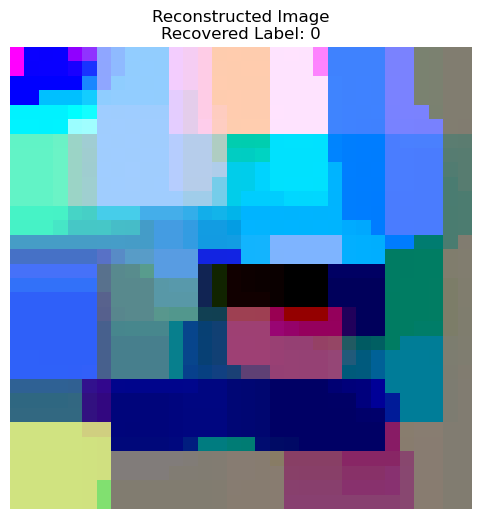

In [9]:
import matplotlib.pyplot as plt

print("Attack Results: ")
print(f"Reconstructed data shape: {reconstructed_user_data['data'].shape}")
print(f"Recovered label: {reconstructed_user_data['labels'].item()}")

# Image stats
print(f"\nImage stats (before denormalization):")
print(f"  Min: {reconstructed_img.min():.4f}")
print(f"  Max: {reconstructed_img.max():.4f}")
print(f"  Mean: {reconstructed_img.mean():.4f}")

# Check if stats dict has useful info
if 'opt' in stats:
    print(f"\nFinal optimization loss: {stats['opt']:.6f}")

# Denormalize and visualize
img = reconstructed_img.detach().clone()
img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)

# Denormalize
mean = torch.tensor((0.5071, 0.4867, 0.4408))
std = torch.tensor((0.2675, 0.2565, 0.2761))
img = img * std + mean

# Clip to valid range
img = torch.clamp(img, 0, 1)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy())
plt.title(f"Reconstructed Image\nRecovered Label: {reconstructed_user_data['labels'].item()}")
plt.axis('off')
plt.savefig('reconstructed_final.png', dpi=150, bbox_inches='tight')
plt.show()